I have used the following methods.

* I used a pretrained <b>Faster R-CNN with ResNet-50 Region Proposal Network</b> from detectron2 [1,2]
* I have modified the official notebook [3]

## Test Set Predictions
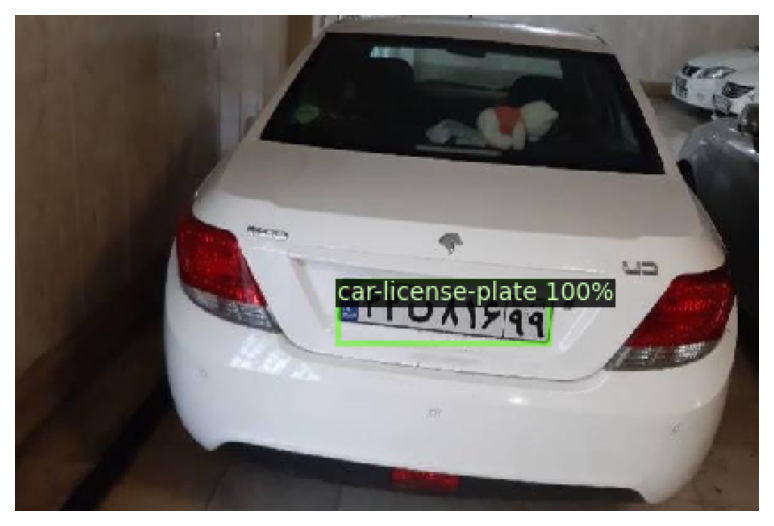
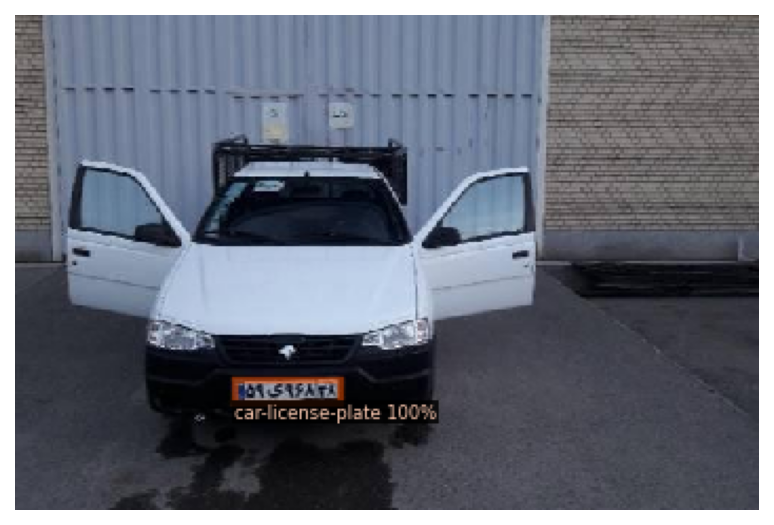


## References
1. Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1506.01497
2. https://detectron2.readthedocs.io/en/latest/
3. https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [ ]:
import sys, os, distutils.core
from IPython.display import clear_output

!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
clear_output()

In [ ]:
# Importing dependencies

import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 20
THRESHOLD = 0.9

In [ ]:
# A function for showing an image

def cv2_imshow(a):
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    plt.figure(dpi = 150)
    plt.axis('off')
    plt.imshow(a)

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [ ]:
# Creating coco instances

from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

for set_name in ["train", "valid", "test"]:
    register_coco_instances(f"dataset_{set_name}", {},
                            f"../input/car-license-plate-detection-iran/{set_name}/_annotations.coco.json",
                            f"../input/car-license-plate-detection-iran/{set_name}")

In [ ]:
# Examples from the training dataset

import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("dataset_train")
train_dataset_dicts = DatasetCatalog.get("dataset_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.8, sample_size = 4):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:sample_size]
    
    for im in images:
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        plt.figure(dpi = 150)
        plt.title('image id: ' + str(img_id), fontsize = 10)
        plt.axis('off')
        plt.imshow(final_img)
        

In [ ]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 40 , image_scale = 0.8, sample_size = 2)

# <span style="color:#e74c3c;"> Training </span>

In [ ]:
from detectron2.engine import DefaultTrainer

EPOCHS = 2800
NUM_CLASSES = 2 # there are 2 classes in the json file
BASE_LR = 0.0002  

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train", "dataset_valid")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# original code from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

def reading_metrics_from_json(metrics_path):
    metrics = []
    
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        metric.append(metrics[i][str(specific_metric)])
    return metric

In [ ]:
train_metrics = reading_metrics_from_json('/kaggle/working/output/metrics.json')

iters = metric(train_metrics, 'iteration')
total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (15, 4), dpi = 150)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (Last Accuracy {0:.4f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10)

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, false_neg)
axs[2].set_xlabel('epochs', fontsize = 10)
axs[2].set_title('False Negative', fontsize = 10)

In [ ]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

# <span style="color:#e74c3c;"> Validation </span> Predictions

In [ ]:
my_dataset_test_metadata = MetadataCatalog.get("dataset_valid")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("dataset_valid")

for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im) 
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    v = Visualizer(im, metadata=my_dataset_test_metadata, scale=0.7, instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
    cv2_imshow(out_img)


# <span style="color:#e74c3c;"> Test </span> Evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("dataset_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "dataset_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

# <span style="color:#e74c3c;"> Test </span> Predictions

In [ ]:
my_dataset_test_metadata = MetadataCatalog.get("dataset_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("dataset_test")

for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im) 
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    v = Visualizer(im, metadata=my_dataset_test_metadata, scale=0.7, instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
    cv2_imshow(out_img)